In [377]:
import nibabel as nib
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from pyvis.network import Network
import pandas as pd
import os
import seaborn as sns

from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix

In [121]:
base_path = '/Users/ahmet/Desktop/Study/second_semester/ds_project/BSNIP/pconn'

In [120]:
pconn_paths = os.listdir('/Users/ahmet/Desktop/Study/second_semester/ds_project/BSNIP/pconn')

In [98]:
session_ids = [path.split('.')[0] for path in pconn_paths]

In [88]:
behavior_path = '/Users/ahmet/Desktop/Study/second_semester/ds_project/behavior/'

In [126]:
def read_behavior(path):
    # Reading
    behavior_path = path
    
    behavior_files = os.listdir(behavior_path)
    
    behavior_source = pd.read_csv(behavior_path+behavior_files[0], sep='\t')
    for behavior_file in behavior_files[1:]:
        curr_behavior_source = pd.read_csv(behavior_path+behavior_file, sep='\t')
        behavior_source = pd.concat([behavior_source, curr_behavior_source], axis=0)

    return behavior_source

def read_pconn(path):
    
    # Load the .pconn.nii file
    img = nib.load(path)
    
    # Extract the data array from the image
    # The data might need to be processed or reshaped depending on its structure
    data = img.get_fdata()

    df = pd.DataFrame(data)
    
    return data, df

def build_network(data, df, visualize = True):
    # Create a graph from the data
    # This example assumes 'data' is a square matrix where data[i][j] represents the connection
    # strength between region i and region j. Your data's structure may vary.
    G = nx.Graph()
    
    # Add nodes with the brain region names or indices if you don't have names
    num_regions = data.shape[0]
    G.add_nodes_from(range(num_regions))
    
    # Add edges based on connectivity data
    # Here we're simply adding an edge for every non-zero connection
    for i in range(num_regions):
        # Calculate the standard deviation of the specified row
        std_dev = df.iloc[i].std()
        threshold = 2*std_dev
        for j in range(i+1, num_regions):  # Ensure i < j to avoid duplicating edges
            if abs(data[i, j]) > threshold:  # Assuming 0 means no connection
                G.add_edge(i, j, weight=data[i, j])
    
    if visualize:
        # You can also visualize the graph using matplotlib or similar libraries
        # This step requires matplotlib to be installed (`pip install matplotlib`)
        nx.draw(G, with_labels=True)
        plt.show()
        
    return G

def graph_stats(session_id, G):
    clustering = nx.average_clustering(G)
    edges = G.number_of_edges()
    density = nx.density(G)
    #diameter = nx.diameter(G)
    # min max degree
    degree_sequence = sorted((d for n, d in G.degree()), reverse=True)
    dmax = max(degree_sequence)
    dmin = min(degree_sequence)
    num_connected_components = len(list(nx.connected_components(G)))
    
    stats_dict = {'session_id': session_id,
                'avg_clustering': clustering,
                 'num_of_edges':edges,
                 'denstity': density,
                 #'diameter' : diameter,
                 'max_degree' : dmax,
                'min_degree' : dmin,
                'num_connected_components': num_connected_components}
    
    return stats_dict

In [575]:
df_behavior = read_behavior(behavior_path)

In [135]:
stats = []
for session_id, pconn_path in zip(session_ids, pconn_paths):
    path = os.path.join(base_path, pconn_path)
    data, df = read_pconn(path)
    G = build_network(data, df, visualize = False)
    stats_dict = graph_stats(session_id, G)
    stats.append(stats_dict)

In [136]:
df_stats = pd.DataFrame(stats)

In [507]:
df_ml = df_stats.merge(df[['session_id', 'Group']], how = 'left', on = 'session_id')

In [576]:
df_ml.head()

,session_id,avg_clustering,num_of_edges,denstity,max_degree,min_degree,num_connected_components,Group
0,S3173UOM2,0.346946,11415,0.044347,153,2,1,BPP
1,S9403UJQ1,0.309741,14560,0.056565,113,7,1,CON
2,S8923VMI1,0.427481,36347,0.141207,320,4,1,CON
3,S1352DPR1,0.438013,30951,0.120243,245,8,1,CON
4,S9888YRS2,0.392567,24715,0.096017,195,9,1,BPP


In [567]:
X = df_ml.drop(['Group', 'session_id'], axis=1)
y = df_ml['Group']

le = LabelEncoder()
encoded_y = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, encoded_y, test_size=0.2, random_state=42)

model = xgb.XGBClassifier(objective='multi:softmax', max_depth = 4, reg_lambda = 5, n_estimators = 20, seed=11)
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=20, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', ...)

In [568]:
preds = model.predict(X_test)

In [569]:
pred_train = model.predict(X_train)

In [577]:
print('Train accuracy {}'.format(accuracy_score(y_train, pred_train)))

Train accuracy 0.6450980392156863


In [578]:
print('Test accuracy {}'.format(accuracy_score(y_test, preds)))

Test accuracy 0.328125


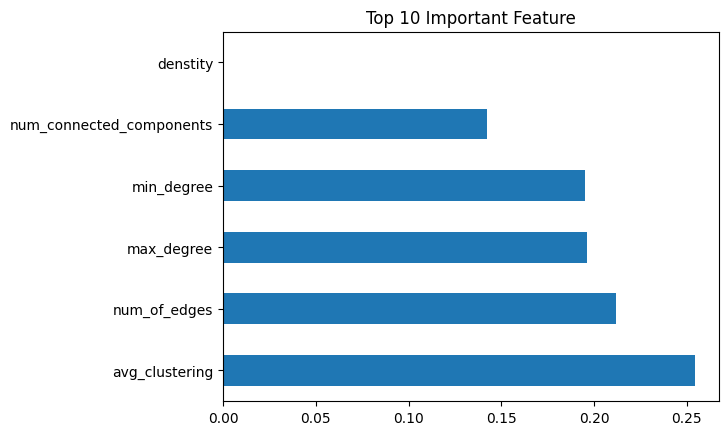

In [579]:
feat_imp = pd.Series(model.feature_importances_, index=X_train.columns).sort_values(ascending = False)
feat_imp[:10].plot(kind = 'barh')
plt.title('Top 10 Important Feature')
plt.show()

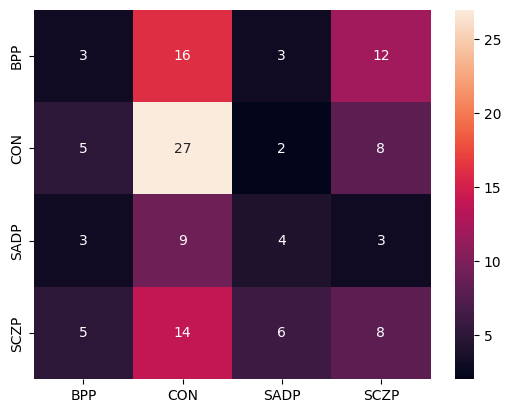

In [581]:
sns.heatmap(confusion_matrix(y_test, preds), annot = True, xticklabels = le.classes_, yticklabels = le.classes_);